In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext line_profiler

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
sess_config = tf.ConfigProto()

import sys
import os

COCO_DATA = '../data/fss_cell'
MASK_RCNN_MODEL_PATH = '../lib/Mask_RCNN/'
SIAMESE_MASK_RCNN_PATH = '../lib/'

if MASK_RCNN_MODEL_PATH not in sys.path:
    sys.path.append(MASK_RCNN_MODEL_PATH)
if SIAMESE_MASK_RCNN_PATH not in sys.path:
    sys.path.append(SIAMESE_MASK_RCNN_PATH)
    
from samples.coco import coco
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
    
import utils as siamese_utils
import model as siamese_model
import config as siamese_config
   
import time
import datetime
import random
import numpy as np
import skimage.io
import imgaug
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [2]:
MODEL_DIR

'/auto/master07/vincentwu929/siamese-mask-rcnn/experiments/logs'

## Dataset

In [3]:
# Load COCO/val dataset
test_dataset = siamese_utils.IndexedFssCellDataset()
coco_test_object = test_dataset.load_coco(COCO_DATA, subset="test", return_coco=True)
test_dataset.prepare()
test_dataset.build_indices()

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


## Model

In [4]:
class ParallelTrainConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'fss_cell'
    EXPERIMENT = 'evaluation'
    
    # Large image sizes
    TARGET_MAX_DIM = 192
    TARGET_MIN_DIM = 150
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    # Large model size
    FPN_CLASSIF_FC_LAYERS_SIZE = 1024
    FPN_FEATUREMAPS = 256
    # Large number of rois at all stages
    RPN_ANCHOR_STRIDE = 1
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000
    TRAIN_ROIS_PER_IMAGE = 200
    DETECTION_MAX_INSTANCES = 100
    MAX_GT_INSTANCES = 100
    
class SmallTrainConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'fcc_cell'
    EXPERIMENT = 'evaluation'

In [5]:
config = ParallelTrainConfig()

In [6]:
# Provide training schedule of the model
# When evaluationg intermediate steps the tranining schedule must be provided
short_train_schedule = OrderedDict()
short_train_schedule[1] = {"learning_rate": config.LEARNING_RATE, "layers": "heads"}
short_train_schedule[120] = {"learning_rate": config.LEARNING_RATE, "layers": "all"}
short_train_schedule[160] = {"learning_rate": config.LEARNING_RATE/10, "layers": "all"}

# Provide training schedule of the model
# When evaluationg intermediate steps the tranining schedule must be provided
long_train_schedule = OrderedDict()
long_train_schedule[1] = {"learning_rate": config.LEARNING_RATE, "layers": "heads"}
long_train_schedule[240] = {"learning_rate": config.LEARNING_RATE, "layers": "all"}
long_train_schedule[320] = {"learning_rate": config.LEARNING_RATE/10, "layers": "all"}

## Siamese Mask R-CNN

### All 80 classes

In [ ]:
# Load pretrained checkpoint
config = ParallelTrainConfig()
checkpoint = '../checkpoints/large_siamese_mrcnn_coco_full_0320.h5'

In [ ]:
ckpt_dir = os.path.join(ROOT_DIR, 'logs/parallel_coco_full')
config = ParallelTrainConfig()

# Select checkpoint
step = 320 # usually the last ckpt is the best
checkpoint = os.path.join(ckpt_dir, 'siamese_mrcnn_0{:0>3}.h5'.format(step))

In [ ]:
# Evaluate on all classes
test_dataset.ACTIVE_CLASSES = np.array(range(1,81))

# Load and evaluate models

# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint, training_schedule=long_train_schedule)
# Evaluate only active classes
active_class_idx = np.array(test_dataset.ACTIVE_CLASSES) - 1

# Evaluate on the validation set
print('evaluating five times')

for run in range(5):
    print('\t*** Evaluation run {} ***'.format(run + 1))
    
    siamese_utils.evaluate_dataset(model, test_dataset, coco_test_object, eval_type=["bbox", "segm"], 
                     dataset_type='coco', limit=0, image_ids=None, # limit=0 -> entire data set
                     class_index=active_class_idx, verbose=1)
    
    print('\n' * 5, end='')

### i-split

In [7]:
index = 1 # between 1 and 4

In [8]:
folds = {
    'all': set(range(1, 15)),
    1: set(range(1, 15)) - set(range(1, 3)),
    2: set(range(1, 15)) - set(range(3, 6)),
    3: set(range(1, 15)) - set(range(6, 9)),
    4: set(range(1, 15)) - set(range(9, 11)),
    5: set(range(1, 15)) - set(range(11, 15)),
}

train_classes = np.array(list(folds[index]))
test_classes =  np.array(list(folds['all'] - folds[index]))

In [9]:
#one_shot_classes = np.array([4*i + index for i in range(20)])
#train_classes = np.array(range(1,81))[np.array([i not in one_shot_classes for i in range(1,81)])]

In [10]:
# Load pretrained checkpoint
#checkpoint = '../checkpoints/large_siamese_mrcnn_coco_i{}_0160.h5'.format(index)

In [11]:
# Load self-trained checkpoint
ckpt_dir = os.path.join(ROOT_DIR, 'logs/siamese_mrcnn_fss_cell_i{}'.format(index))
config = ParallelTrainConfig()

# Select checkpoint
step = 5 #160 # usually the last ckpt is the best
checkpoint = os.path.join(ckpt_dir, 'siamese_mrcnn_0{:0>3}.h5'.format(step))

#### train classes

In [12]:
# Evaluate on training classes
test_dataset.ACTIVE_CLASSES = test_classes

# Load and evaluate models

# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint, training_schedule=short_train_schedule)
# Evaluate only active classes
active_class_idx = np.array(test_dataset.ACTIVE_CLASSES) - 1

# Evaluate on the validation set
print('evaluating five times')

for run in range(5):
    print('\t*** Evaluation run {} ***'.format(run + 1))
    
    siamese_utils.evaluate_dataset(model, test_dataset, coco_test_object, eval_type=["bbox", "segm"], 
                     dataset_type='fss_cell', limit=0, image_ids=None, 
                     class_index=active_class_idx, verbose=1)
    
    print('\n' * 5, end='')

W0304 13:13:47.152560 140287920523072 deprecation_wrapper.py:119] From /home/master/07/vincentwu929/anaconda3/envs/pytorch/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:504: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0304 13:13:47.178035 140287920523072 deprecation_wrapper.py:119] From /home/master/07/vincentwu929/anaconda3/envs/pytorch/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0304 13:13:47.181680 140287920523072 deprecation_wrapper.py:119] From /home/master/07/vincentwu929/anaconda3/envs/pytorch/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3828: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0304 13:13:47.210499 140287920523072 deprecation_wrapper.py:119] From /home/master/07/vincentwu929/anaconda3/envs/pytorch/lib/python3.7/site-packages/keras/back

loading /auto/master07/vincentwu929/siamese-mask-rcnn/experiments/logs/siamese_mrcnn_fss_cell_i1/siamese_mrcnn_0005.h5 ...
starting from epoch 5
evaluating five times
	*** Evaluation run 1 ***
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.36s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.010
 Average Recall     (AR) @[ IoU=0.

KeyboardInterrupt: 

#### one-shot classes

In [ ]:
# Evaluate on one-shot classes
test_dataset.ACTIVE_CLASSES = one_shot_classes

# Load and evaluate models

# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint, training_schedule=short_train_schedule)
# Evaluate only active classes
active_class_idx = np.array(test_dataset.ACTIVE_CLASSES) - 1

# Evaluate on the validation set
print('evaluating five times')

for run in range(5):
    print('\t*** Evaluation run {} ***'.format(run + 1))
    
    siamese_utils.evaluate_dataset(model, test_dataset, coco_test_object, eval_type=["bbox", "segm"], 
                     dataset_type='coco', limit=0, image_ids=None, 
                     class_index=active_class_idx, verbose=1)
    
    print('\n' * 5, end='')

### Visualization

In [12]:
# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint, training_schedule=short_train_schedule)

W0304 13:49:12.036883 140277687473984 deprecation_wrapper.py:119] From /home/master/07/vincentwu929/anaconda3/envs/pytorch/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:504: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0304 13:49:12.057103 140277687473984 deprecation_wrapper.py:119] From /home/master/07/vincentwu929/anaconda3/envs/pytorch/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0304 13:49:12.060453 140277687473984 deprecation_wrapper.py:119] From /home/master/07/vincentwu929/anaconda3/envs/pytorch/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3828: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0304 13:49:12.091109 140277687473984 deprecation_wrapper.py:119] From /home/master/07/vincentwu929/anaconda3/envs/pytorch/lib/python3.7/site-packages/keras/back

loading /auto/master07/vincentwu929/siamese-mask-rcnn/experiments/logs/siamese_mrcnn_fss_cell_i1/siamese_mrcnn_0005.h5 ...
starting from epoch 5


image_id 92
Processing 1 images
image                    shape: (488, 488, 3)         min:   12.00000  max:  255.00000  uint8
target                   shape: (1, 1, 192, 192, 3)   min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
molded_targets           shape: (1, 1, 192, 192, 3)   min:    0.00000  max:  242.00000  uint8
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


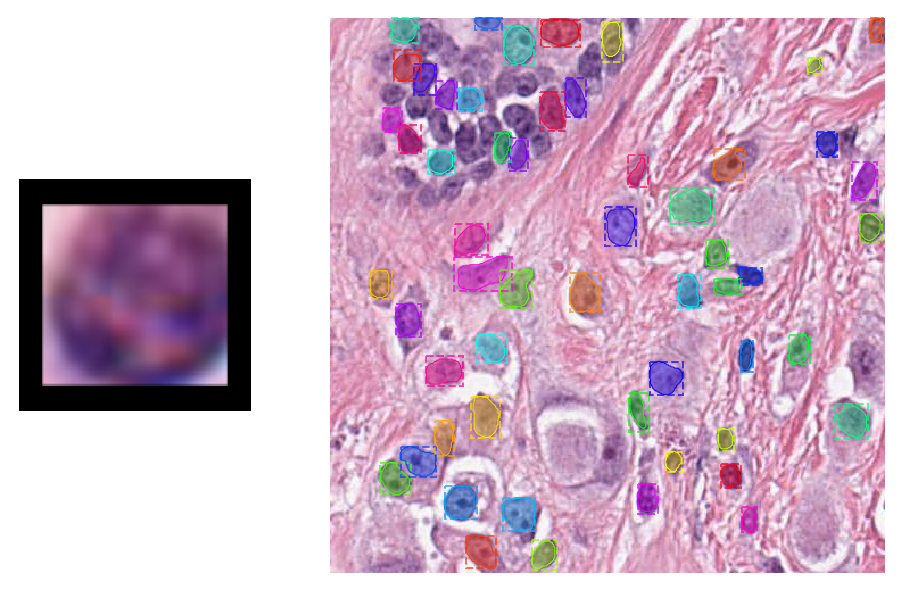

In [13]:
# Select category
category = 10 # np.random.choice(test_classes)

image_id = np.random.choice(test_dataset.category_image_index[category])   
# Load target
target = siamese_utils.get_one_target(category, test_dataset, config)
# Load image
image = test_dataset.load_image(image_id)
print("image_id", image_id)


# Run detection
results = model.detect([[target]], [image], verbose=1)
r = results[0]
# Display results
siamese_utils.display_results(target, image, r['rois'], r['masks'], r['class_ids'], r['scores'])